In [1]:
import xarray as xr
import pymc as pymc
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import datetime
import arviz as az

from scipy.special import expit

from werp_projecting_sfis.file_io import sfi_file_to_pandas 


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
filename = "C:/Users/rob635/OneDrive - CSIRO/WERP/SFI_Projection/Data/_MURR_B0D000__eFA_annual_stats_10discount.txt"
openfile = open(filename)
inlines = openfile.readlines()
inlines

['year_start=1895\n',
 'year_end=2009\n',
 ' \n',
 '[Barmah-Millewa Forest]\n',
 'rule count=7\n',
 'BMF_R1=1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0\n',
 'BMF_R2=0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0\n',
 'BMF_R3=0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0\n',
 'BMF_R4=0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0

In [3]:
outstruct = dict()
sitelist = list()
for line in inlines:
    if ("year_start" in line):
        outstruct['year_start'] = int(line.split("=")[1].split("\n")[0])
    if ("year_end" in line):
        outstruct['year_end'] = int(line.split("=")[1].split("\n")[0])
    if ("[" in line):
        sitename = line.split("[")[1].split("]")[0]
        sitelist.append(sitename)
nlines = len(inlines)
ln = 0
while ln < nlines:
    flags = [ st in inlines[ln] for st in sitelist]  
    if (any(flags)):
        sitename = sitelist[ np.where(flags)[0][0]]
        nrules = int(inlines[ln+1].split("=")[1])
        rules = dict()
        for rule in range(nrules):
            linesplit = inlines[ln+2+rule].split("=")
            outlongsplit = linesplit[1].split(",")

            rules[linesplit[0]]=[float(val) for val in outlongsplit]

        outstruct[sitename] = rules
        ln = ln + nrules + 2


    ln = ln +1


print(outstruct)

{'year_start': 1895, 'year_end': 2009, 'Barmah-Millewa Forest': {'BMF_R1': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'BMF_R2': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

In [4]:
timeindex = pd.date_range(start=(str(outstruct['year_start'])+"-07-01"), 
                               end = (str(outstruct['year_end'])+"-06-30"),
                               freq = "YE-JUN")
outstruct["time"]= timeindex

In [5]:
len(outstruct[sitelist[1]]['GKP_R1'])


114

In [6]:

outlist = list()
for site in sitelist:
    outlist.append( pd.DataFrame(outstruct[site], index = timeindex))
outdf = pd.concat(outlist, axis = 1, join='inner')
outdf

,BMF_R1,BMF_R2,BMF_R3,BMF_R4,BMF_R5,BMF_R6,BMF_R7,GKP_R1,GKP_R2,GKP_R3,...,EDW_R1,EDW_R2,EDW_R3,EDW_R4,EDW_R5,LDF_R1,LDF_R2,LDF_R3,LDF_R4,LDF_R5
1896-06-30,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1897-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1898-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1899-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1900-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
inflowfile = "C:/Users/rob635/OneDrive - CSIRO/WERP/SFI_Projection/Data/InflowData_from modelled outputs_P0H/MURR.csv"

inpredictor = pd.read_csv(inflowfile)
inpredictor['date'] = pd.to_datetime(inpredictor['date'])
inpredictor.set_index('date', inplace=True)
inpredictor
annualpredictor = inpredictor.resample("YE-JUN").sum()
annualpredictor

,inflow,outflow,local
date,,,
1896-06-30,8322251.0,3376607.0,5.651775e+06
1897-06-30,6021355.0,2139088.0,4.251536e+06
1898-06-30,8828884.0,1583839.0,5.022850e+06
1899-06-30,8595550.0,2523049.0,6.169939e+06
1900-06-30,8050405.0,2877384.0,5.119717e+06
...,...,...,...
2005-06-30,7253731.0,1711289.0,5.462452e+06
2006-06-30,8887863.0,2754732.0,6.492137e+06
2007-06-30,2910648.0,723644.0,2.152755e+06


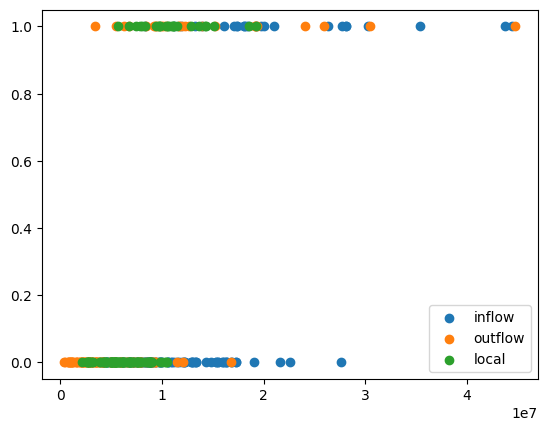

In [8]:
for col in annualpredictor.columns:
    plt.scatter(annualpredictor[col], outdf['BMF_R1'], label = col)

plt.legend()

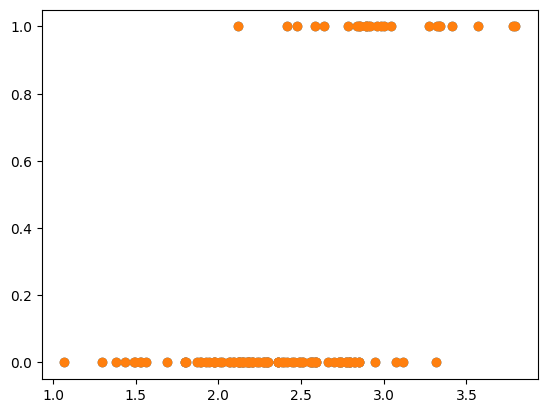

In [9]:
data = pd.concat([annualpredictor['inflow'],outdf['BMF_R1']],axis=1, join='inner')
data['inflow'] = np.log(data['inflow']/1000000)

data = data.reset_index()[data.columns[-2:]]

plt.scatter(x=data['inflow'], y= data['BMF_R1'])

data = data.sort_values(by = 'inflow')

plt.scatter(x=data['inflow'], y= data['BMF_R1'])

Add.0 p


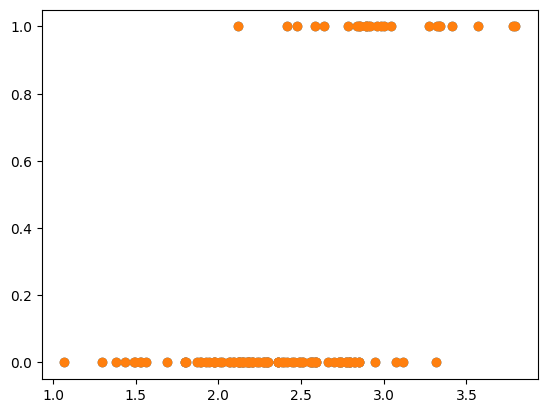

In [10]:
data = pd.concat([annualpredictor['inflow'],outdf['BMF_R1']],axis=1, join='inner')
data['inflow'] = np.log(data['inflow']/1000000)

data = data.reset_index()[data.columns[-2:]]

plt.scatter(x=data['inflow'], y= data['BMF_R1'])

data = data.sort_values(by = 'inflow')
n = 1 #data.shape[0]

plt.scatter(data['inflow'], data['BMF_R1'], label = col)

with pymc.Model() as binomial_regression_model:
    x = pymc.Data("x", (data['inflow']))
    # priors
    beta0 = pymc.Normal("beta0", mu=0, sigma=100)
    beta1 = pymc.Normal("beta1", mu=0, sigma=100)
    # linear model
    mu = beta0 + beta1 * x
    p = pymc.Deterministic("p", pymc.math.invlogit(mu))
    print(mu, p)
    # likelihood
    pymc.Binomial("y", n=n, p=p, observed=data['BMF_R1'])

In [15]:
with binomial_regression_model:
    idata = pymc.sample(2000, tune=4000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1]


Output()

Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 51 seconds.


array([[<Axes: title={'center': 'beta0'}>,
        <Axes: title={'center': 'beta0'}>],
       [<Axes: title={'center': 'beta1'}>,
        <Axes: title={'center': 'beta1'}>]], dtype=object)

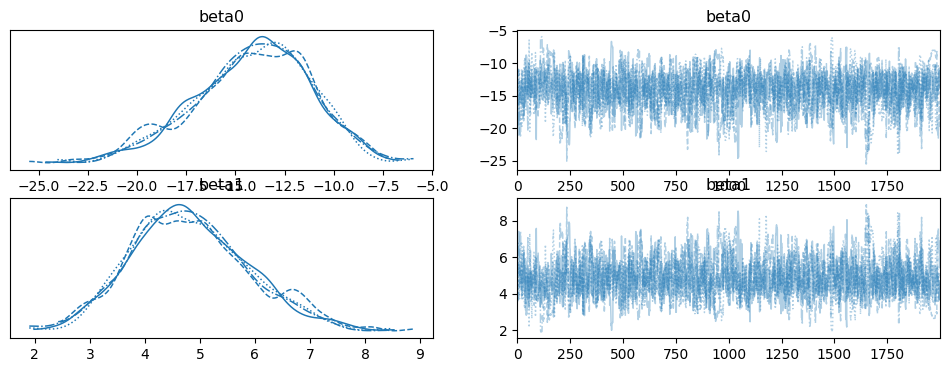

In [16]:
az.plot_trace(idata, var_names=["beta0", "beta1"])

In [17]:
p_true = (data["BMF_R1"])

C:\Users\rob635\AppData\Local\Temp\ipykernel_31424\1434495412.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1].legend(facecolor="white", frameon=True);


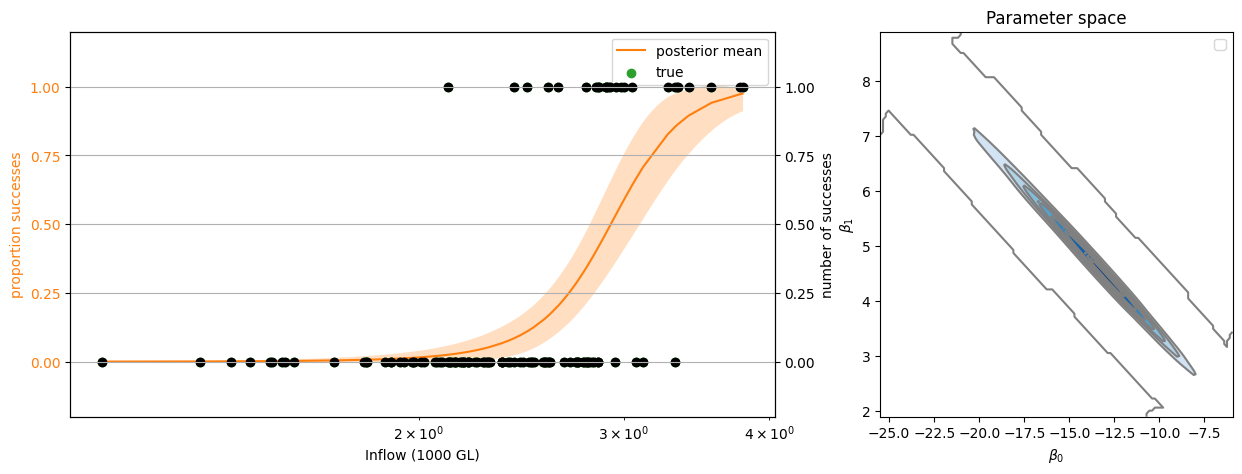

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(15,5), gridspec_kw={"width_ratios": [2, 1]})

# Data space plot ========================================================
az.plot_hdi(
    data["inflow"],
    idata.posterior.p,
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.25, "linewidth": 0},
    ax=ax[0],
    color="C1",
)
# posterior mean
post_mean = idata.posterior.p.mean(("chain", "draw"))
ax[0].plot(data["inflow"], post_mean, label="posterior mean", color="C1")
# plot truth
ax[0].scatter(data["inflow"], p_true,  label="true", color="C2")
# formatting
ax[0].set(xlabel="Inflow (1000 GL)")
ax[0].set_ylabel("proportion successes", color="C1")
ax[0].tick_params(axis="y", labelcolor="C1")
ax[0].legend()
ax[0].set_xscale('log')
# instantiate a second axes that shares the same x-axis
freq = ax[0].twinx()
freq.set_ylabel("number of successes")
freq.scatter(data["inflow"], data["BMF_R1"], color="k", label="data")
# get y-axes to line up
y_buffer = 0.2
freq.set(ylim=[-y_buffer, n + y_buffer])
ax[0].set(ylim=[-(y_buffer / n), 1 + (y_buffer / n)])
freq.grid(None)
# set both y-axis to have 5 ticks
ax[0].set(yticks=np.linspace(0, n, 5) / n)
freq.set(yticks=np.linspace(0, n, 5))

# Parameter space plot ===================================================
az.plot_kde(
    az.extract(idata, var_names="beta0"),
    az.extract(idata, var_names="beta1"),
    contourf_kwargs={"cmap": "Blues"},
    ax=ax[1],
)
#ax[1].plot(beta0_true, beta1_true, "C2o", label="true")
ax[1].set(xlabel=r"$\beta_0$", ylabel=r"$\beta_1$", title="Parameter space")
ax[1].legend(facecolor="white", frameon=True);

In [120]:
binomial_regression_model.debug()

point={'beta0': array(1.), 'beta1': array(1.)}

The variable y has the following parameters:
0: [114] [id A] <Vector(int32, shape=(1,))>
1: Sigmoid [id B] <Vector(float64, shape=(?,))> 'p'
 └─ Add [id C] <Vector(float64, shape=(?,))>
    ├─ ExpandDims{axis=0} [id D] <Vector(float64, shape=(1,))>
    │  └─ beta0 [id E] <Scalar(float64, shape=())>
    └─ Mul [id F] <Vector(float64, shape=(?,))>
       ├─ ExpandDims{axis=0} [id G] <Vector(float64, shape=(1,))>
       │  └─ beta1 [id H] <Scalar(float64, shape=())>
       └─ x [id I] <Vector(float64, shape=(?,))>
The parameters evaluate to:
0: [114]
1: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Some of the observed values of variable y are a